In [60]:
import csv
import googletrans
import matplotlib.pyplot as plt
import time


from collections import Counter
from pandas import DataFrame
from random import sample

### Dataset Paths

In [5]:
TRAIN_ENG="data/train_en.csv"
TRAIN_TCN="data/train_tcn.csv"
DEV_ENG="data/dev_en.csv"
DEV_TCN="data/dev_tcn.csv"
TEST_TCN="data/test_tcn.csv"

### Data Denoise and Collection

Dataset contains very poor and inconsistent handling of double quotes. For the ENG datasets, the only real value of the double quote is to indicate 'inches' for measurements in certain contexts. Otherwise, double quotes have no real value and can be removed. The dataset is also not a true CSV, with inconsistent number of columns in the dataset. This problem is also present in the TCN dataset.

After manually analyzing the errors, here's how we can recover most of the broken data:

1. Replace all \" (backslash double quote) with a placeholder.

2. Remove all ", then recover all \"

3. Don't use Python CSV reader, perform manual string splits by commas. Use rfind to find last comma, which indicates the start of the category label, except for the "Toys, Games & Collectibles" category. We handle that as a special case.

4. If line does not have commas, it will be rolled over (prepended) to the next line (this is because actual data is broken over multiple lines, most likely because user had a newline in the input which team did not sanitize)

In [6]:
hardcoded_eng_categories = ["Hobbies & Stationery",
                            "Health & Personal Care",
                            "Mobile Accessories",
                            "Home & Living",
                            "Women's Apparel",
                            "Women Shoes",
                            "Babies & Kids",
                            "Women Accessories",
                            "Toys, Games & Collectibles",
                            "Groceries",
                            "Motors",
                            "Makeup & Fragrances",
                            "Women's Bags",
                            "Men's Apparel",
                            "Pet Care",
                            "Men's Bags & Accessories",
                            "Sports & Travel",
                            "Men Shoes",
                            "Gaming",
                            "Laptops & Computers",
                            "Home Entertainment",
                            "Mobiles & Gadgets",
                            "Cameras",
                            "Home Appliances",
                            "Consumer Electronics",
                            "Digital Goods & Vouchers"]
hardcoded_eng_categories = set(hardcoded_eng_categories)

In [7]:
hardcoded_tcn_categories = ["Health & Beauty",
                            "Game Kingdom",
                            "Life & Entertainment",
                            "Mother & Baby",
                            "Men's Apparel",
                            "Women's Apparel",
                            "Women Bags",
                            "Women Shoes",
                            "Home & Living",
                            "Everything Else",
                            "Hardware & 3C",
                            "Men's Bags& Accessories",
                            "Sports & Outdoors",
                            "Helpbuy",
                            "Men Shoes",
                            "Books",
                            "Motors",
                            "Home Electronic",
                            "Food & Beverages",
                            "Mobile & Gadgets",
                            "Women Accessories",
                            "Pets",
                            "Tickets & Services"]
hardcoded_tcn_categories = set(hardcoded_tcn_categories)

In [8]:
def get_eng_data(filename, categories=hardcoded_eng_categories, LIMIT=-1):

    rows = []
    
    with open(filename) as f:
        
        count = 0
        
        # Ignore header
        next(f)
        
        # Setup rollover
        prev = ""
        
        # Iterate over lines
        for line in f:
            line = prev + " " + line
            line = line.replace('\\"', "<XXX>")
            line = line.replace('"', '')
            line = line.replace("<XXX>", '"').strip()
            
            tokens = line.split(",")
            if len(tokens) == 1: # no commas
                prev = line
                continue
                            
            category = tokens[-1] # Category is the last token
            
            # Check against list of categories so we don't admit nonsense
            if category not in categories:
                            
                # Handle special case            
                if "Games & Collectibles" in category:
                    category = "{}, {}".format(tokens[-2].strip(), tokens[-1].strip())
                    rows.append((",".join(tokens[:-2]), category))
                else:
                    continue                
            else:
                rows.append((",".join(tokens[:-1]), category))
                
            prev = "" # Clear out rollover
                
            count += 1
            
            # Early terminate if specified
            if LIMIT >= 0 and count >= LIMIT:
                break
            
    return rows
    

def get_tcn_data(filename, categories=hardcoded_tcn_categories, LIMIT=-1):
    
    rows = []
    
    with open(filename) as f:
        
        count = 0
        
        # Ignore header
        next(f)
        
        # Setup rollover
        prev = ""
        
        # Iterate over lines
        for line in f:
            
            line = prev + line
            comma_index = line.rfind(",")
            if comma_index < 0:
                prev = line
                continue
                                
            category = line[comma_index + 1:].strip() # Category is the last token
            
            
            # Check against list of categories so we don't admit nonsense
            if category not in categories:
                continue

            rows.append((line[:comma_index].strip(), category))
                
            prev = "" # Clear out rollover
                
            count += 1
            
            # Early terminate if specified
            if LIMIT >= 0 and count >= LIMIT:
                break
            
    return rows


def get_generic_data(filename, LIMIT=-1):
    
    rows = []
    
    with open(filename) as f:
        
        count = 0
        
        # Ignore header
        next(f)
        
        # Iterate over lines
        for line in f:
            
            rows.append((line.strip(), "private"))
            count += 1
            
            # Early terminate if specified
            if LIMIT >= 0 and count >= LIMIT:
                break
            
    return rows


In [23]:
# Define a sample size for viewing sample parsing results
SAMPLE_SIZE=10

In [24]:
train_eng_data = get_eng_data(TRAIN_ENG)
for ex in sample(train_eng_data, SAMPLE_SIZE):
    print(ex[0])
print("Read {} examples.".format(len(train_eng_data)))

2 COPY small desibo 10pcs
Original Coach Sling BUY1 TAKE1
TV/Movie Inspired T Shirt Game of Thrones SNOW KNOWS
ALL NATURAL DAY MOISTURIZER
MEN'S CLUB Army Green Polo Shirt Unisex
Tom Silver 92.5 Italy Sterling Silver Classic Stud Stone Earring TESS127-4MM
FARMSTAY PURE CLEANSING FOAM (GREEN TEA)
Limited Edition Designers Wallets New Arrival Class A-Premium #EZ
April skin pinky piggy set
I Work Out Pet Dog Cat Shirt Clothes
Read 503193 examples.


In [25]:
train_tcn_data = get_tcn_data(TRAIN_TCN)
for ex in sample(train_tcn_data, SAMPLE_SIZE):
    print(ex[0])
print("Read {} examples.".format(len(train_tcn_data)))

新店新品上市618熱賣 燕麥色輕奢氣質哈倫褲秋季新款OL職業女褲捲邊長褲休閒小腳西褲褲 【快速出貨】
❤️現貨+預購❤️嬰兒套裝 100%純棉 嬰幼兒服 秋冬長袖外套 長袖哈衣 長褲👖三件套裝0-1-2歲
加拿大楓糖茶包任選3$600
法蘭克 穆勒 Franck Muller V45 SC DT 手錶 男錶 男女手錶 更多款式聊聊咨詢499
【可居家居】韓版/田園風 可愛花邊棉質圍裙 工作服小碎花韓式家居服
YQ下單區 高單價1000-2000
生物學實驗      第二版
7.18新品 耐吉男鞋 NIKE FREE 5.0飛線赤足透氣女子運動鞋跑步鞋 尺寸36-39號
#現貨秒殺￥octopusme章魚家毛呢西裝外套女中長款2020新款秋冬繭型格子大衣
現貨新品正品👟New Balance 便利帆布袋 卡其(NBGC7F7207IV) 黑
Read 500295 examples.


In [30]:
dev_eng_data = get_generic_data(DEV_ENG)
for ex in sample(dev_eng_data, SAMPLE_SIZE):
    print(ex[0])
print("Read {} examples.".format(len(dev_eng_data)))

Long version Pocket Cardigan Knit Coat
Tree De Sc Multifunctional Locker - Scm3 - 3M6S
Polo Shirt Classic Embroidery Polo Shirt (CUSTOM FIT)
【 HARIO 】 Black Vacuum Insulation Pot 02 VHS - 60B
Japan Maruman A5 Loose-Leaf Blank Notebook * Hn183A
Keyway RC - 830 Lily Wide Type Anti Slip Chair Replacement
Gymboree US Kids Baby Hat Bear 0 - 3M 3 - 6M 6 - 12M
Haruhi The Melancholy Episode02 Limited Edition Dvd+Storage Box
Nike Men Jordan H86 D.Y.K. Cap Leisure Caps
The sak Green Algae Feed Thin PC 25g Floating Type Shaped Peacock Fish Lily
Read 1000 examples.


In [31]:
dev_tcn_data = get_tcn_data(DEV_TCN, categories=set(["private", "public"]))
for ex in sample(dev_tcn_data, SAMPLE_SIZE):
    print(ex[0])
print("Read {} examples.".format(len(dev_tcn_data)))

愛貓零食5入混合35g
EYUP SABRI TUNCER迷你淡香水-琥珀與玫瑰16ml 土耳其航空指定品牌
Kimo 戶外休閒鞋 黑色 女鞋 no544
粉色 睫毛 眼睛 iPhone8 iPhone7 6s Plus I6 I7 i8 手機殼
KGH 帆布籃球包 行軍包 韓版男女後背包 大容量運動包 803RR4357
台灣JNS鈣反應器第二反應管 X-1 免運
FM collection-質感真皮休閒小白鞋-12260001
Faber-Castell輝柏 1207 0.7mm筆芯 / 盒
QUEENSHOP 【01022815】男裝 漸層牛仔襯衫 S/M/L/XL＊預購＊
美國 Kid O 交通系列-噗噗車-藍
Read 1000 examples.


In [32]:
test_tcn_data = get_eng_data(TEST_TCN, categories=set(["private", "public"]))
for ex in sample(test_tcn_data, SAMPLE_SIZE):
    print(ex[0])
print("Read {} examples.".format(len(test_tcn_data)))

小叮噹的店- AP222《艾弗瑞》鋼琴表演(2)
mt WRAP(標準補充包) ・William Morris Arbutus mt和紙自黏包裝紙
全館免運/黑色款少兒童成人軟底練功鞋廣場舞鞋 YX041729
法國品牌 YAY You Are Young 台北ShopSmart直營店 Sultane 粉水晶長項鍊 金色 可調式
原野大廚鮮肉乾系列II
mac 鍵盤膜 彩色注音倉頡 鍵盤膜s219
ASICS 亞瑟士GEL-QUANTUM 360 KNIT 頂級慢跑鞋 女 T778N7690 Big-O Sports
KID 灰藍迷彩連帽斗篷
【巴黎丁】Filorga 菲洛嘉 去角質注氧泡泡面膜 55ml
Hello Kitty 鑽殼施華洛世奇原廠授權 水鑽5吋HTC Desire 530630626650D530U
Read 10000 examples.


### Category Analysis

Brief look at the distribution of categories for products. Note that categories were only provided for the initial two training ENG and TCN datasets. The new dev datasets and the test datasets effectively have no category labels, so YMMV.

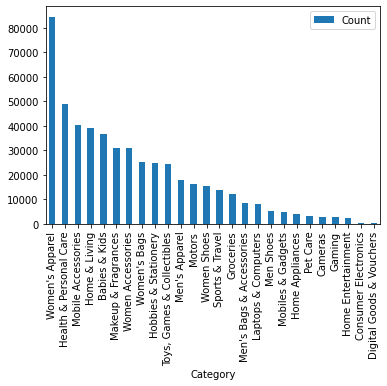

In [12]:
# Training English Categories
train_eng_categories = Counter(list(zip(*train_eng_data))[1])
train_eng_categories_df = DataFrame(sorted(train_eng_categories.items(), key=lambda x: x[1], reverse=True), columns=["Category", "Count"])
train_eng_categories_df.plot(kind="bar", x="Category")

plt.show()

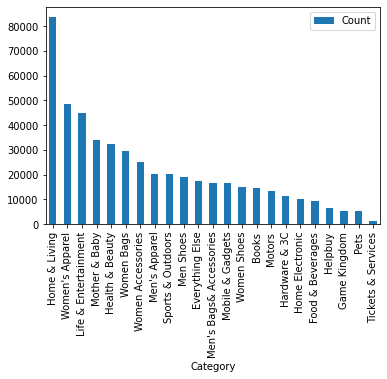

In [13]:
# Training Chinese Categories
train_tcn_categories = Counter(list(zip(*train_tcn_data))[1])
train_tcn_categories_df = DataFrame(sorted(train_tcn_categories.items(), key=lambda x: x[1], reverse=True), columns=["Category", "Count"])
train_tcn_categories_df.plot(kind="bar", x="Category")

plt.show()

### Direct Translation Using Google Translate

First, let's figure out a decent baseline result using Google Translate. We can use `googletrans`, a nice and convenient wrapper around the Google Translate API.

In [27]:
from googletrans import Translator

translator = Translator()

In [54]:
0 % 500

0

In [69]:
def get_chinese_phrases(text):
    return re.findall(r'[\u4e00-\u9fff]+', text)

def is_chinese(text):
    return len(get_chinese_phrases(text)) > 0

def tcn_to_eng(data, batch_size=250, log_freq=100, backoff=3, limit=-1):

    count = 0
    skipped = 0
    failed = 0

    translator = None
    start_time = time.time()
    output = []
    
    for datum in data:
        
        # Reset translator every batch and take a break
        if count % batch_size == 0:
            translator = Translator()
            time.sleep(2)
            
        tries = 0
        translated = False
        
        # Check if text contains any TCN
        if len(get_chinese_phrases(datum)) == 0:
            
            skipped += 1
            output.append(datum)
            
        else:
        
            # Go into backoff loop
            while tries < backoff:

                candidate = translator.translate(datum, src="zh-CN", dest="en").text
                chinese_phrases = get_chinese_phrases(candidate)                
                
                # Check if translator failed
                if candidate == datum:
                    
                    tries += 1
                    print("Translation try {} out of {} failed for '{}'. Retrying...".format(tries, backoff, datum))
                    time.sleep(3)
                    translator = Translator()
                    continue
                    
                # Translated some, but still contains TCN phrases, perform phrase based translation
                elif len(chinese_phrases) > 0:
                    
                    translated_phrases = [translator.translate(phrase, src="zh-CN", dest="en").text for phrase in chinese_phrases]
                    
                    # Check that all phrases have been successfully translated
                    if len([p for p in translated_phrases if is_chinese(p)]) > 0:
                        
                        tries += 1
                        print("Translation (phrase) try {} out of {} failed for '{}'. Retrying...".format(tries, backoff, datum))
                        time.sleep(3)
                        translator = Translator()
                        continue
                        
                    else:
                        output.append(candidate)
                        translated = True
                        break
                    
                else:
                    output.append(candidate)
                    translated = True
                    break
            
            if not translated:
                print("Failed to translate {}.".format(datum))
                failed += 1
                
        count += 1
        
        # Log stats
        if count % log_freq == 0:
            print("Processed {} examples in {}s. Skipped {}. Failed {}.".format(count, time.time() - start_time, skipped, failed))
    
    return output
        
        


In [70]:
baseline_predictions = tcn_to_eng([t[0] for t in test_tcn_data])

Processed 100 examples in 15.714834928512573s. Skipped 0. Failed 0.
Processed 200 examples in 26.255562782287598s. Skipped 0. Failed 0.
Processed 300 examples in 39.6618275642395s. Skipped 0. Failed 0.


KeyboardInterrupt: 

In [33]:
# This takes a long time for 10k queries

BASELINE_PREDICTIONS = "predictions_baseline.csv"

baseline_translations = translator.translate([tup[0] for tup in test_tcn_data], src="zh-CN", dest="en")
with open(BASELINE_PREDICTIONS, "w") as f:
    writer = csv.writer(f, quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(["translation_output"])
    for translation in baseline_translations:
        writer.writerow([translation.text])

### Refine Predictions

Frequently, the translation engine fails for mixed language strings. We go over the predictions again and extract the segments that are still untranslated, and translate them on a phrase-based basis.

In [53]:
refined_translations = []
with open("predictions_refined.csv", "r") as f:
    reader = csv.reader(f, quotechar='"')
    next(reader)
    count = 0
    for row in reader:
        
        count += 1
        if count >= 3000:
            break
            
        chinese_chars = re.findall(r'[\u4e00-\u9fff]+', row[0])
        if len(chinese_chars) == 0:
            new_preds.append(row[0])
            continue
     
        translated_segments = []
        for chinese_char in chinese_chars:
            translated_segments.append(translator.translate(chinese_char, src="zh-CN", dest="en").text)
            if len(re.findall(r'[\u4e00-\u9fff]+', translated_segments[-1])) > 0:
                print(count)
                print(row[0])
                print(translated_segments)
                print(1 / 0)
            
        translation = row[0]
        for source, target in zip(chinese_chars, translated_segments):            
            translation = translation.replace(source, " " + target + " ")
            
        #print(row[0] + " -> " + translation)
        refined_translations.append(translation)        

1809
 笑笑羊第二季 ： 化妝舞會 
['笑笑羊第二季']


ZeroDivisionError: division by zero

In [51]:
with open("predictions_refined.csv", "w") as f:
    writer = csv.writer(f, quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(["translation_output"])
    for translation in refined_translations:
        writer.writerow([translation])

### Refine by Deduplication

In [49]:
with open("data/train_en.csv", "r") as f:
    next(f)
    for line in f:
        last_token = None
        tokens = line.strip().split()
        
        for token in tokens:
            if token == last_token:
                print(line)
            last_token = token

MIU MIU Vitello Lux Leather Handbag,Women's Bags

mask mask 50pcs per box,Health & Personal Care

yugioh kumootoko original original single card,"Toys, Games & Collectibles"

AeroCool P7-C1 Black Black 0.6mm ATX Mid Tower Computer Case,Cameras

Justin Hurwitz ‎– La La Land  CD,"Toys, Games & Collectibles"

Washable Facemask Matchy Matchy with free garter,Health & Personal Care

Club a. cava cava leather ankle boots Preloved,Women Shoes

Sailor Moon Moon Stick Liquid Eyeliner Sailormoon,Makeup & Fragrances

Factory direct labor safety shoes shoes safety,Women Shoes

Red Santa Ho Ho Ho Baby Christmas Tutu Dress Set,Babies & Kids

Red Santa Ho Ho Ho Baby Christmas Tutu Dress Set,Babies & Kids

*pbb* Tsum Tsum Duo - Mike Wazowksi & Sulley Lipsmacker,Makeup & Fragrances

samsung j7 j7 core glow in the dark soft tpu case,Mobile Accessories

Samsung phone case A5 2016/A510/A5 2017/A520/A6 PLUS/A7 2016/A710/A7 2018/A8 2018/A8 PLUS/A50 B7,Mobile Accessories

We Bear Bear Grizzle 3D Hard Case fo

60mL Milk Milk Outdoor Travel Drinking Bottle Juice etc Nursing Baby Natural Water Casual Water,Babies & Kids

COD hugo boss  boss US tester perfume,Makeup & Fragrances

Floral Semi Semi Swing Dress,Women's Apparel

Preloved Hush Hush Newborn Basics,Babies & Kids

An An Preloved Blouse. Fits M-L,Women's Apparel

11 11 hard case for Samsung Galaxy A10s A20s A30s A50s,Mobile Accessories

KATHY# SALE SALE SALE korea pouch&bear 3in1 backpack,Women's Bags

KATHY# SALE SALE SALE korea pouch&bear 3in1 backpack,Women's Bags

Hush Hush & Crescendo by Becca Fitzpatrick,Hobbies & Stationery

RJ RJ Acoustic Guitar Masa - 3  - Red Color,Hobbies & Stationery

Disney Tsum Tsum Monster Inc. Hair Tie,Women Accessories

Litchi Leather Case for Huawei P9 P9 PLUS High Quality Ultr,Mobile Accessories

women apparel black dress plus size dress dress casual,Women's Apparel

NEW NEW LADIES Bag TOTEBAG/SHOULDERBAG,Women's Bags

Holika Holika Holi Pop BB Cream,Makeup & Fragrances

Black Swarm Iphone xr x xs xs 

SALE! SALE! Huggies Dry Pants Large 30pcs/pack,Babies & Kids

Samsung case A5 2016/A510/A5 2017/A520/A6 PLUS/A7 2016/A710/A7 2018/A8 2018/A8 PLUS/A50 25,Mobile Accessories

HOLIKA HOLIKA Wonder drawing 24HR Auto Eyeliner,Makeup & Fragrances

Dashing Diva Bling Bling Gel Strip DGNP58,Makeup & Fragrances

COD Oppo F3 F3 Ring bracket case oppo case 2in1 case,Mobile Accessories

2020 new jacket jacket unisex hoodie long sleeve,Women's Apparel

Mio Mio by Silverworks X4206 Set of 3 Spike Stud Earrings,Women Accessories

Tsum Tsum Pluto Figural Keyring,Hobbies & Stationery

Sale! Sale! Denim Dress,Women's Apparel

Preloved Preloved -C- celebrity pink jeans co.,Women's Apparel

（Food）Samsung case A5 2016/A510/A5 2017/A520/A6 PLUS/A7 2016/A710/A7 2018/A8 2018/A8 PLUS/A50,Mobile Accessories

Paw Paw Rosehip & Manuka Lip Balm,Makeup & Fragrances

Sol de Janeiro Brazilian moisturizing shower cream gel / Sol de janeiro bum bum set,Health & Personal Care

Doggy Doggy Syrup Performance Enhancer Supp

jumpsui denim dress elegant dress korean dress dress casual,Women's Apparel

Miu Miu Matelasse crossbody bag AUTHENTIC,Women's Bags

Hush Hush Baby Girls 3-piece Lucky Charm Bloomer Shorts Set,Babies & Kids

Lululemon Lululemon leggings activewear,Sports & Travel

lgkcph lgkcph Korean Sling Bag 2018042365,Women's Bags

M L bang bang aldous unisex,Men's Apparel

🇯🇵 Shitajiki Anime B5 Assorted Dragonball Yu Yu Hakusho,"Toys, Games & Collectibles"

Live selling sale sale sale,Babies & Kids

"Tickle, Plastic scratch, Looking handle tickle tickle scratch back tickle tickle.",Hobbies & Stationery

US UKAY UKAY JOGGING PANTS FOR MEN AND WOMEN.,Women's Apparel

Realme Realme 2 C2 3 5 Pro Max Full Cover Temper Glass,Mobile Accessories

Master oil.   - - - Lubricates. Polishes. Cleans,Motors

Master oil.   - - - Lubricates. Polishes. Cleans,Motors

DSN Samsung case A5 2016/A510/A5 2017/A520/A6 PLUS/A7 2016/A710/A7 2018/A8 2018/A8 PLUS/A50↓,Mobile Accessories

Bargain Sale! C I T Y L O O P,Women 

Anti social social club shirt,Men's Apparel

PERIPERA Ink Tint Serum (#5 Go Go Red),Makeup & Fragrances

Sale Sale Sale Blak Stripe Dress,Women's Apparel

Sale Sale Sale Blak Stripe Dress,Women's Apparel

Summer dress 2018 new style slim slim dress printed long spl,Women's Apparel

cardigan... ☺️ ☺️ ☺️,Women's Apparel

Bimtoy Chanpu Chanpu Loose Toothbrush Shark,"Toys, Games & Collectibles"

PROMO PROMO 50% OFF COMFORTER  ONLY,Home & Living

Takara Tomy Movin Movin Pixar Flik A Bug's Life,Babies & Kids

ACBC g u c c i e ALMA BAG,Women's Bags

Sale! Sale! Sale! Original MK Nylon Zip Around Wallet,Women Accessories

Sale! Sale! Sale! Original MK Nylon Zip Around Wallet,Women Accessories

Holika Holika Pig Nose Clear,Health & Personal Care

OriginaI Air Jordan 1 Mid AJ1 High High Top Men's Shoes,Men Shoes

Dashing Diva Bling Bling Gel Strip DGNP50,Makeup & Fragrances

Educational Learning Color Childrens Work Book Book For Kids,Hobbies & Stationery

Sportsheets Sex In The Shower Shower Ge

dolce dolce gabbana perfume for women 75ml,Makeup & Fragrances

Tarte Big Big Blush On Book 2,Makeup & Fragrances

AMERICAN RAG Men shorts branded cargo pants preloved plus size size 38,Men's Apparel

"\European and American fashion Bohemian retro seven-piece suit earrings earrings earring earrings\""""",Women Accessories

Original Bana Bana Long Wallet,Women Accessories

Bible Verse iPhone Snap Matte Case for 5c 5s 6s 6+ 7 7+ 8 8+ X XS Max XR 11 11 Pro 11 Pro Max,Mobile Accessories

Hiphop girls cool clothes new chic Hong Kong taste loose loose handsome short-sleeved T-shirt,Women's Apparel

Ssx 150/200 mask . . . .,Sports & Travel

Ssx 150/200 mask . . . .,Sports & Travel

[ Basket Ball ] Snap phone Case for Oppo F1s F5 F9 F11 F11 Pro,Mobile Accessories

SALE!! SALE!! SALE!!,Health & Personal Care

SALE✅ SALE✅ SALE✅ MOTHER-DAUGHTER WATCHES,Men's Bags & Accessories

SALE✅ SALE✅ SALE✅ MOTHER-DAUGHTER WATCHES,Men's Bags & Accessories

iPhone 7 7 Plus Otterbox Defender Case Shockproof SA


Sale Sale Sale Candy pants,Women's Apparel

bea velvet velvet velvet velvet velvet velvet,Women's Apparel

bea velvet velvet velvet velvet velvet velvet,Women's Apparel

bea velvet velvet velvet velvet velvet velvet,Women's Apparel

bea velvet velvet velvet velvet velvet velvet,Women's Apparel

Sale! Sale! Sale! Ladies TShirt (Code: LF23) with Free  Makeup Pouch,Women's Apparel

Sale! Sale! Sale! Ladies TShirt (Code: LF23) with Free  Makeup Pouch,Women's Apparel

Hanging cute smile coral fleece towel towel kitchen thickening absorbent lint rag dishcloth,Home & Living

"NINTENDO 3DS , WHITE, BLUE AND RED WITH MANY MANY Games",Gaming

L O U I S V U I T T O N,Women's Bags

Electric pan shabu shabu baking pan,Home & Living

SAMSUNG S8 S8 PLUSFLAMINGO FULL COVER CASE,Mobile Accessories

💞 SALE SALE 💞 BRANDED OVERRUN 💞 (2-3 YEARS OLD),Babies & Kids

Casematic White Bear Snap Case Matte for Huawei Enjoy 9 P10 P20 P20 Pro P20 Lite P30 P30 Pro Y56/Y5,Mobile Accessories

Casematic White Bear Sn